[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sebastiancordoba/emotion_generation/blob/main/emotion_generation.ipynb)

In [1]:
import subprocess

subprocess.run(["curl", "-L", "-o", "archive.zip", "https://www.kaggle.com/api/v1/datasets/download/msambare/fer2013"])

CompletedProcess(args=['curl', '-L', '-o', 'archive.zip', 'https://www.kaggle.com/api/v1/datasets/download/msambare/fer2013'], returncode=0)

In [2]:
import os
import zipfile

# Set the path to the zip file
zip_file = 'archive.zip'

# Unzip the file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('FACIAL')  #

# Check if files are successfully unzipped
os.listdir('FACIAL')

['train', 'test']

In [3]:
from google.colab import drive
import os
import torch

# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [14]:
from torch.utils.data import ConcatDataset

# Set the path to your dataset
data_dir = 'FACIAL'

# Image transformations: Resize and Normalize
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize images between -1 and 1
])

# Load training and test data
train_data = datasets.ImageFolder(root=f'{data_dir}/train', transform=transform)
test_data = datasets.ImageFolder(root=f'{data_dir}/test', transform=transform)

# Combine train_data and test_data using ConcatDataset
combined_data = ConcatDataset([train_data, test_data])

# Create a single DataLoader for both train and test data
combined_loader = DataLoader(combined_data, batch_size=64, shuffle=True)

# Check the combined dataset length and class labels
print(f"Total number of images: {len(combined_data)}")
print(train_data.classes)  # Output the class names


Total number of images: 35887
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [15]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [16]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim=100, num_classes=7, img_size=64):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.net = nn.Sequential(
            nn.Linear(z_dim + num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, img_size*img_size),  # Output for 64x64 image
            nn.Tanh()
        )

    def forward(self, z, labels):
        # Concatenate noise vector and label embedding
        label_embedding = self.label_emb(labels)
        input = torch.cat((z, label_embedding), dim=1)
        return self.net(input).view(-1, 1, 64, 64)  # Reshape to (batch_size, 1, 64, 64)

In [17]:
class Discriminator(nn.Module):
    def __init__(self, img_size=64, num_classes=7):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.net = nn.Sequential(
            nn.Linear(img_size*img_size + num_classes, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Binary classification: Real or Fake
        )

    def forward(self, x, labels):
        # Concatenate image and label embedding
        label_embedding = self.label_emb(labels)
        input = torch.cat((x.view(x.size(0), -1), label_embedding), dim=1)
        return self.net(input)

In [18]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import os

# Create a directory to save the plots
os.makedirs('epoch_plots', exist_ok=True)

# Initialize lists to store losses
g_losses = []
d_losses = []

# List of emotion labels, matching the order in which images are generated
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

def plot_progress(generator, g_loss, d_loss, epoch, z_dim=100, num_classes=7):
    """Plots two generated images per emotion on the left, loss curves on the right, and adds labels. Saves the plot each epoch."""

    # Append the current losses to the lists
    g_losses.append(g_loss)
    d_losses.append(d_loss)

    # Set up the figure with a black background
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    fig.patch.set_facecolor('black')  # Set the overall background color to black

    # ------- Left Side: Image Grid -------
    ax1.set_facecolor('black')  # Set the background of the left plot to black
    ax1.set_title('Generated Faces for Each Emotion', color='white', fontsize=16)

    # Generate 2 images for each emotion
    num_images = 2 * num_classes
    z = torch.randn(num_images, z_dim).to(device)
    labels = torch.cat([torch.full((2,), i, dtype=torch.long) for i in range(num_classes)]).to(device)  # Create 2 labels per emotion

    generator.eval()  # Set generator to evaluation mode
    with torch.no_grad():
        generated_images = generator(z, labels).detach().cpu()

    # Rearrange images to stack pairs vertically
    indices = []
    for i in range(2):  # For each image per class
        for j in range(num_classes):  # For each class
            indices.append(j * 2 + i)
    rearranged_images = generated_images[indices]

    # Create a grid of images and display them
    img_grid = vutils.make_grid(rearranged_images, nrow=num_classes, normalize=True)
    ax1.imshow(img_grid.permute(1, 2, 0))  # Permute to match the expected format for imshow (H, W, C)
    ax1.axis('off')  # Hide axes

    # Add labels under each column
    x_offset = 5
    for i, emotion in enumerate(emotion_labels):
        x_position = i * (64 + 2) + x_offset  # Adjust 'x_offset' to move labels right
        ax1.text(x_position, 140, emotion, color='white', fontsize=10, ha='center')


    # ------- Right Side: Loss Plot -------
    ax2.set_facecolor('black')  # Set the background of the right plot to black
    ax2.set_title('Generator and Discriminator Losses', color='white', fontsize=16)

    # Plot the loss curves
    ax2.plot(g_losses, label='Generator Loss', color='red')
    ax2.plot(d_losses, label='Discriminator Loss', color='blue')

    # Labels and settings for the loss plot
    ax2.set_xlabel('Epoch', color='white', fontsize=12)
    ax2.set_ylabel('Loss', color='white', fontsize=12)
    ax2.legend(loc='upper right')
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)

    # Set axis color to white
    ax2.tick_params(axis='x', colors='white')
    ax2.tick_params(axis='y', colors='white')
    ax2.spines['bottom'].set_color('white')
    ax2.spines['left'].set_color('white')

    # Save the figure
    plt.savefig(f'epoch_plots/epoch_{epoch+1}.png', facecolor='black')  # Save the plot with a black background

    # Display the figure
    plt.tight_layout()
    plt.show()


In [ ]:
import torch.optim as optim

# Initialize models
num_classes = 7  # Number of emotions: 'angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'
generator = Generator(z_dim=100, num_classes=num_classes).to(device)
discriminator = Discriminator(num_classes=num_classes).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Loss function
loss_fn = nn.BCELoss()

import time  # Import the time module

# Training parameters
num_epochs = 100
z_dim = 100  # Size of the random noise vector

for epoch in range(num_epochs):
    start_time = time.time()  # Start timing the epoch

    for real_images, labels in combined_loader:  # Get real images and their labels
        batch_size = real_images.size(0)

        # Move real images and labels to GPU
        real_images = real_images.to(device)
        labels = labels.to(device)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ====== Train Discriminator ======
        optimizer_D.zero_grad()

        # Loss for real images
        real_images = real_images.view(batch_size, -1)
        real_preds = discriminator(real_images, labels)
        real_loss = loss_fn(real_preds, real_labels)

        # Generate fake images
        z = torch.randn(batch_size, z_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)  # Random labels for generation
        fake_images = generator(z, gen_labels)

        # Loss for fake images
        fake_preds = discriminator(fake_images.detach(), gen_labels)
        fake_loss = loss_fn(fake_preds, fake_labels)

        # Total loss for discriminator
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # ====== Train Generator ======
        optimizer_G.zero_grad()

        # Generate fake images and calculate loss
        z = torch.randn(batch_size, z_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        fake_images = generator(z, gen_labels)
        preds = discriminator(fake_images, gen_labels)
        g_loss = loss_fn(preds, real_labels)  # Generator tries to fool discriminator

        # Backpropagation and optimization
        g_loss.backward()
        optimizer_G.step()

    # End timing the epoch
    end_time = time.time()
    epoch_duration = end_time - start_time

    # Plot progress
    plot_progress(generator, g_loss.item(), d_loss.item(), epoch)
    print(f"Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, Time: {epoch_duration:.2f} seconds")

In [ ]:
# Crear una carpeta en Google Drive para guardar los modelos
save_dir = '/content/drive/My Drive/FACIALGAN/saved_models'
os.makedirs(save_dir, exist_ok=True)

# Función para guardar el modelo en la carpeta de Google Drive
def save_model(generator, discriminator, epoch, save_dir):
    """Guarda los modelos de generador y discriminador en Google Drive."""
    torch.save(generator.state_dict(), f'{save_dir}/generator_epoch_{epoch+1}.pth')
    torch.save(discriminator.state_dict(), f'{save_dir}/discriminator_epoch_{epoch+1}.pth')
    print(f"Models saved at epoch {epoch+1}")

# Guardar los modelos al final del entrenamiento
save_model(generator, discriminator, num_epochs, save_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Models saved at epoch 101


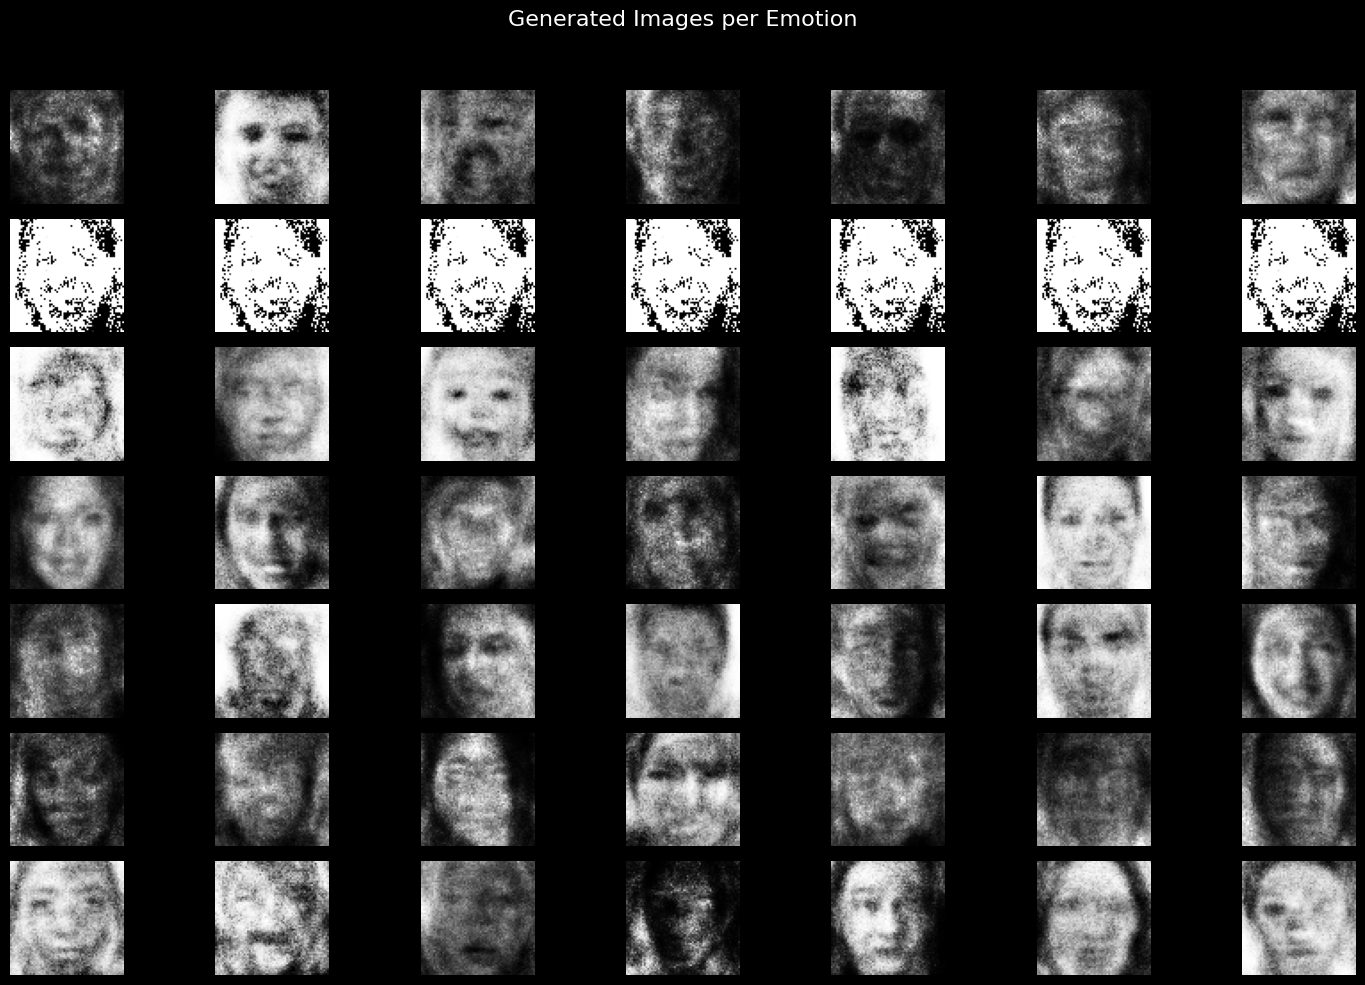

In [ ]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Lista de emociones (asumiendo que estas son las etiquetas)
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Función para generar imágenes
def generate_images_per_emotion(generator, z_dim=100, num_images_per_emotion=7, num_classes=7):
    """Genera 'num_images_per_emotion' imágenes por cada emoción y las visualiza."""
    generator.eval()  # Modo de evaluación (no queremos gradientes aquí)

    # Figura para mostrar las imágenes
    fig, axs = plt.subplots(num_classes, num_images_per_emotion, figsize=(15, 10))
    fig.suptitle('Generated Images per Emotion', color='white', fontsize=16)
    fig.patch.set_facecolor('black')  # Fondo negro

    # Generar imágenes por emoción
    for i, emotion in enumerate(emotion_labels):
        # Generar ruido aleatorio
        z = torch.randn(num_images_per_emotion, z_dim).to(device)

        # Crear etiquetas para la emoción actual (el valor de 'i' corresponde a la emoción)
        labels = torch.full((num_images_per_emotion,), i, dtype=torch.long).to(device)

        # Generar las imágenes con el generador entrenado
        with torch.no_grad():
            generated_images = generator(z, labels).detach().cpu()

        # Mostrar las imágenes en una cuadrícula
        for j in range(num_images_per_emotion):
            img = generated_images[j]
            axs[i, j].imshow(img.permute(1, 2, 0).squeeze(), cmap='gray')
            axs[i, j].axis('off')  # Ocultar los ejes

        # Añadir etiquetas de emociones en la primera columna
        axs[i, 0].set_ylabel(emotion, color='white', fontsize=12, labelpad=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar la cuadrícula y el espacio para el título
    plt.show()

# Llamada a la función para generar 7 imágenes por emoción
generate_images_per_emotion(generator)


In [ ]:
import os
import imageio

# Path where the saved plots are stored
image_folder = 'epoch_plots'
images = []

# Loop through all the images in the folder, sorting them by epoch
for file_name in sorted(os.listdir(image_folder), key=lambda x: int(x.split('_')[1].split('.')[0])):
    if file_name.endswith('.png'):
        file_path = os.path.join(image_folder, file_name)
        images.append(imageio.imread(file_path))

# Save the images as a gif
gif_path = 'epoch_plots_training.gif'
imageio.mimsave(gif_path, images, fps=5)

print(f"GIF saved at {gif_path}")


<ipython-input-53-9c0a3ef6b821>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


GIF saved at epoch_plots_training.gif
